## A basic set of tools for visualizing FESOM2.0 simulations

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
## import standard python packages

In [3]:
# import standard python packages
import sys
import numpy as np
# import basemap
from mpl_toolkits.basemap import Basemap
# import FESOM packages
sys.path.append("./modules/")
from load_mesh_data import *
from regriding import fesom2clim
sys.path.append("/home/h/hbkdsido/utils/seawater-1.1/")
import seawater as sw
from fesom_plot_tools import *
import cmocean.cm as cmo
import matplotlib 
fontsize=20
matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize) 

## read the mesh

In [10]:
# set the path to the mesh

meshpath  ='/work/ollie/pscholz/mesh_fesom2.0/mesh_CORE2_finaltopo_mean/'

alpha, beta, gamma=[50, 15, -90]

try:
	mesh
except NameError:
	print("mesh will be loaded")
	mesh=load_mesh(meshpath, abg=[alpha, beta, gamma], usepickle = False)
else:
	print("mesh with this name already exists and will not be loaded")
    
    
from ut import *
runid    ='fesom'
ncfile   =Dataset(os.path.join('/work/ollie/dsidoren/transport_paper/run_c2/fesom.mesh.diag.nc'))
edges    =ncfile.variables['edges'][:]-1
el_nodes =ncfile.variables['elem'][:,:]-1
edge_dxdy=ncfile.variables['edge_cross_dxdy'][:]
edge_tri =ncfile.variables['edge_tri'][:]-1
nlevels  =ncfile.variables['nlevels'][:]-1
zbar     =ncfile.variables['zbar'][:]
nodes_x =ncfile.variables['nodes'][0,:]*180./np.pi
nodes_y =ncfile.variables['nodes'][1,:]*180./np.pi
el_area =ncfile.variables['elem_area'][:]
# compute lon/lat coordinate of an element required lated for binning
elem_x  =nodes_x[el_nodes].sum(axis=0)/3.
elem_y  =nodes_y[el_nodes].sum(axis=0)/3.
ncfile.close()

mesh with this name already exists and will not be loaded


## computing MOC from vertical velocity

In [19]:
result_path ='/work/ollie/dsidoren/transport_paper/run_c3/'
records, year=np.linspace(0,0,1).astype(int), 1991
nlats=181
lats=np.linspace(-90, 90, nlats)
dlat=lats[1]-lats[0]
# allocate moc array
moc=np.zeros([mesh.nlev, nlats])
# compute MOC
# precompute positions of elements for binning
pos = ((elem_y-lats[0])/dlat).astype('int')

# compute contributions from vertical velocities on elements and put them into bins
for i in range(mesh.nlev):
# read the model result from fesom.XXXX.oce.nc
    w1=read_fesom_slice('w', records, year, mesh, result_path, runid, ilev=i)
    w2=read_fesom_slice('bolus_w', records, year, mesh, result_path, runid, ilev=i)
    w=w1+w2
#     print(i)
    # mean over elements
    elem_mean = np.sum(w[el_nodes[:,:]], axis=0)/3.*1.e-6
    # weigh by element area
    elem_mean_weigh = el_area*elem_mean
    # select nodes to consider in calculation based on number of levels
    toproc = np.where(i <=  nlevels-1)[0]
    # for every bin select elements that belong to the bin and sum them.
    for k in range(pos.min(), pos.max()+1):
#         if (i <= nlevels[e]-1):
            moc[i, k]=elem_mean_weigh[toproc][pos[toproc]==k].sum()

# the result from the previous step needs to be cumulatively summed 
moc = np.ma.cumsum(np.ma.masked_invalid(moc), axis=1)

/home/ollie/dsidoren/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:28: UserWarning: Warning: converting a masked element to nan.


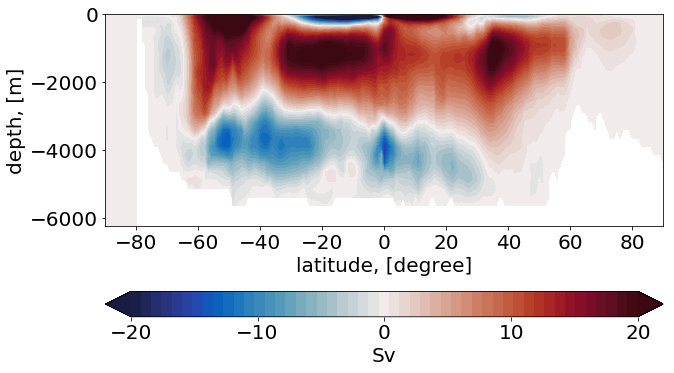

In [20]:
cbartext, cont = 'Sv', [-20., 20., .1]
cmap=cmo.balance
fig = plt.figure(figsize=(10,6))
plt.contourf(lats, mesh.zlev, moc, cmap=cmap, levels=np.linspace(cont[0], cont[1], 50), extend='both')
plt.xlabel('latitude, [degree]', fontsize=fontsize)
plt.ylabel('depth, [m]', fontsize=fontsize)
cbar=plt.colorbar(orientation="horizontal", pad=.2)
cbar.set_ticks([round(i,4) for i in np.linspace(cont[0], cont[1], 5)])
cbar.set_label(cbartext, fontsize=fontsize)
cbar.set_label(cbartext, fontsize=fontsize)

## computing MOC from meridional velocity

In [21]:
year=1991
result_path ='/work/ollie/dsidoren/transport_paper/run_c3/'
std_dens=-mesh.zlev
std_dens=np.array(std_dens)
std_densN=len(std_dens)

# define a descrete set of latitudes
nlats=181
lats=np.linspace(-90, 90, nlats)
# allocate moc array
moc   =np.zeros([std_densN, nlats])
drhodz=np.zeros([std_densN, nlats])


edge_dxdy_l=np.array([ edge_dxdy[1,:], -edge_dxdy[0,:]])
edge_dxdy_r=np.array([-edge_dxdy[3,:],  edge_dxdy[2,:]])
edge_dxdy_r[:, edge_tri[1,:]<0]=0.

u   =0.
v   =0.
rhoz=0.
ncfile = Dataset(os.path.join(result_path, 'U_rho_x_DZ.fesom.'+str(year)+'.nc'))
u      = u+ncfile.variables['U_rho_x_DZ'][:].mean(axis=0)
ncfile.close()

ncfile = Dataset(os.path.join(result_path, 'V_rho_x_DZ.fesom.'+str(year)+'.nc'))
v      = v+ncfile.variables['V_rho_x_DZ'][:].mean(axis=0)
ncfile.close()

#zonally averaged dRHO/dZ is used for diagnosing numerical mixing from dMOC
ncfile = Dataset(os.path.join(result_path, 'RHO_Z.fesom.'+str(year)+'.nc'))
rhoz   = rhoz+ncfile.variables['RHO_Z'][:].mean(axis=0)
ncfile.close()
    
#for i in range(u.shape[1]):
#    u[nlevels==i,i:]=0.
#    v[nlevels==i,i:]=0.
x_el=(mesh.x2[el_nodes].mean(axis=0))
y_el=(mesh.x2[el_nodes].mean(axis=0))
for I,Y in enumerate(lats):
    ind=((mesh.y2[edges[0,:]]-Y)*(mesh.y2[edges[1,:]]-Y) < 0.)
    ind2=(mesh.y2[edges[0,:]] <= Y)
    edge_dxdy_l[:, ind2]=-edge_dxdy_l[:, ind2]
    edge_dxdy_r[:, ind2]=-edge_dxdy_r[:, ind2]
    
    res1=(edge_dxdy_l[0,ind]*u[edge_tri[0,ind],:].T).sum(axis=1)
    res2=(edge_dxdy_l[1,ind]*v[edge_tri[0,ind],:].T).sum(axis=1)
    res3=(edge_dxdy_r[0,ind]*u[edge_tri[1,ind],:].T).sum(axis=1)
    res4=(edge_dxdy_r[1,ind]*v[edge_tri[1,ind],:].T).sum(axis=1)
    
    [vec_x, vec_y]=vec_rotate_r2g(alpha, beta, gamma, x_el[edge_tri[0,ind]], y_el[edge_tri[0,ind]], edge_dxdy_l[0,ind], edge_dxdy_l[1,ind], 1)    
    res5=(np.abs(vec_x)*rhoz[edge_tri[0,ind],:].T).sum(axis=1)
    [vec_x, vec_y]=vec_rotate_r2g(alpha, beta, gamma, x_el[edge_tri[1,ind]], y_el[edge_tri[1,ind]], edge_dxdy_r[0,ind], edge_dxdy_r[1,ind], 1)    
    res6=(np.abs(vec_x)*rhoz[edge_tri[1,ind],:].T).sum(axis=1)
    
    moc[:,I]   =-np.cumsum((res1+res2+res3+res4)[::-1])*1.e-6
    drhodz[:,I]= res5+res6
    
    edge_dxdy_l[:, ind2]=-edge_dxdy_l[:, ind2]
    edge_dxdy_r[:, ind2]=-edge_dxdy_r[:, ind2]

moc=-np.flipud(moc)
moc[-1,:]   =0.
drhodz[-1,:]=0.


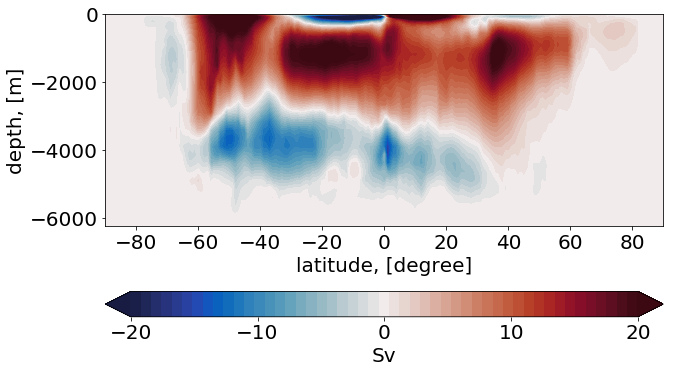

In [22]:
cbartext, cont = 'Sv', [-20., 20., .1]
cmap=cmo.balance
fig = plt.figure(figsize=(10,6))
plt.contourf(lats, -std_dens, moc, cmap=cmap, levels=np.linspace(cont[0], cont[1], 50), extend='both')
plt.xlabel('latitude, [degree]', fontsize=fontsize)
plt.ylabel('depth, [m]', fontsize=fontsize)
cbar=plt.colorbar(orientation="horizontal", pad=.2)
cbar.set_ticks([round(i,4) for i in np.linspace(cont[0], cont[1], 5)])
cbar.set_label(cbartext, fontsize=fontsize)
cbar.set_label(cbartext, fontsize=fontsize)

## computing MOC in density coordinate

In [24]:
year=1991
result_path ='/work/ollie/dsidoren/transport_paper/run_c2/'
# these shall be the density bins which are specified in gen_modules_diag.F90
std_dens=[0.0000,   30.00000, 30.55556, 31.11111, 31.66667, 32.22222, 
32.77778, 33.33333, 33.88889, 34.44444, 35.00000, 35.10622, 
35.20319, 35.29239, 35.37498, 35.45187, 35.52380, 35.59136, 
35.65506, 35.71531, 35.77247, 35.82685, 35.87869, 35.92823, 
35.97566, 36.02115, 36.06487, 36.10692, 36.14746, 36.18656, 
36.22434, 36.26089, 36.29626, 36.33056, 36.36383, 36.39613, 
36.42753, 36.45806, 36.48778, 36.51674, 36.54495, 36.57246, 
36.59932, 36.62555, 36.65117, 36.67621, 36.70071, 36.72467, 
36.74813, 36.77111, 36.79363, 36.81570, 36.83733, 36.85857, 
36.87940, 36.89985, 36.91993, 36.93965, 36.95904, 36.97808, 
36.99682, 37.01524, 37.03336, 37.05119, 37.06874, 37.08602, 
37.10303, 37.11979, 37.13630, 37.15257, 37.16861, 37.18441, 37.5, 37.75, 40.]

#std_dens=-mesh.zlev
std_dens=np.zeros(1000)
std_dens[0]=0
std_dens[1:]=10.5/1000.
std_dens[1:]=27.5+np.cumsum(std_dens[1:])

#std_dens=np.zeros(1000)
#std_dens[0]=0
#std_dens[1:]=7000./1000.
#std_dens[1:]=np.cumsum(std_dens[1:])

std_dens=np.array(std_dens)
std_densN=len(std_dens)

# define a descrete set of latitudes
nlats=181
lats=np.linspace(-90, 90, nlats)
# allocate moc array
moc   =np.zeros([std_densN, nlats])
drhodz=np.zeros([std_densN, nlats])


edge_dxdy_l=np.array([ edge_dxdy[1,:], -edge_dxdy[0,:]])
edge_dxdy_r=np.array([-edge_dxdy[3,:],  edge_dxdy[2,:]])
edge_dxdy_r[:, edge_tri[1,:]<0]=0.

u   =0.
v   =0.
rhoz=0.
ncfile = Dataset(os.path.join(result_path, 'U_rho_x_DZ.fesom.'+str(year)+'.nc'))
u      = u+ncfile.variables['U_rho_x_DZ'][:].mean(axis=0)
ncfile.close()

ncfile = Dataset(os.path.join(result_path, 'V_rho_x_DZ.fesom.'+str(year)+'.nc'))
v      = v+ncfile.variables['V_rho_x_DZ'][:].mean(axis=0)
ncfile.close()

#zonally averaged dRHO/dZ is used for diagnosing numerical mixing from dMOC
ncfile = Dataset(os.path.join(result_path, 'RHO_Z.fesom.'+str(year)+'.nc'))
rhoz   = rhoz+ncfile.variables['RHO_Z'][:].mean(axis=0)
ncfile.close()
    
#for i in range(u.shape[1]):
#    u[nlevels==i,i:]=0.
#    v[nlevels==i,i:]=0.
x_el=(mesh.x2[el_nodes].mean(axis=0))
y_el=(mesh.x2[el_nodes].mean(axis=0))
for I,Y in enumerate(lats):
    ind=((mesh.y2[edges[0,:]]-Y)*(mesh.y2[edges[1,:]]-Y) < 0.)
    ind2=(mesh.y2[edges[0,:]] <= Y)
    edge_dxdy_l[:, ind2]=-edge_dxdy_l[:, ind2]
    edge_dxdy_r[:, ind2]=-edge_dxdy_r[:, ind2]
    
    res1=(edge_dxdy_l[0,ind]*u[edge_tri[0,ind],:].T).sum(axis=1)
    res2=(edge_dxdy_l[1,ind]*v[edge_tri[0,ind],:].T).sum(axis=1)
    res3=(edge_dxdy_r[0,ind]*u[edge_tri[1,ind],:].T).sum(axis=1)
    res4=(edge_dxdy_r[1,ind]*v[edge_tri[1,ind],:].T).sum(axis=1)
    
    [vec_x, vec_y]=vec_rotate_r2g(alpha, beta, gamma, x_el[edge_tri[0,ind]], y_el[edge_tri[0,ind]], edge_dxdy_l[0,ind], edge_dxdy_l[1,ind], 1)    
#   vec_x=edge_dxdy_l[0,ind]
    res5=(np.abs(vec_x)*rhoz[edge_tri[0,ind],:].T).sum(axis=1)
    [vec_x, vec_y]=vec_rotate_r2g(alpha, beta, gamma, x_el[edge_tri[1,ind]], y_el[edge_tri[1,ind]], edge_dxdy_r[0,ind], edge_dxdy_r[1,ind], 1)    
#   vec_x=edge_dxdy_r[0,ind]
    res6=(np.abs(vec_x)*rhoz[edge_tri[1,ind],:].T).sum(axis=1)
    
#   moc[:,I]   =-np.cumsum((res1+res2+res3+res4))*1.e-6
    moc[:,I]   =-np.cumsum((res1+res2+res3+res4)[::-1])*1.e-6
    drhodz[:,I]= res5+res6
    
    edge_dxdy_l[:, ind2]=-edge_dxdy_l[:, ind2]
    edge_dxdy_r[:, ind2]=-edge_dxdy_r[:, ind2]

moc=-np.flipud(moc)

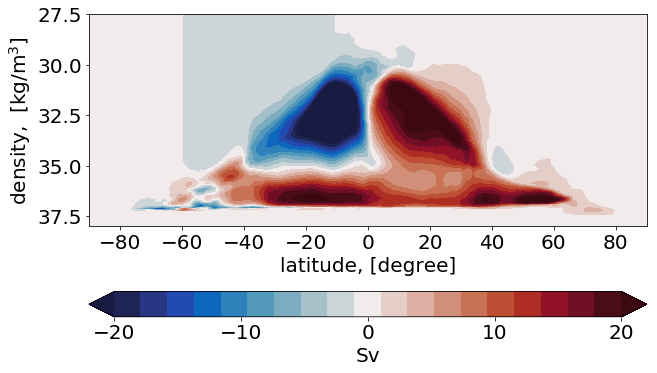

In [26]:
import matplotlib.cm as cm
fig = plt.figure(figsize=(10,6))
cbartext, cont = 'Sv', [-20., 20.]
moc[abs(moc)==0.] =np.nan
moc[np.isnan(moc)]=0.1
flt=np.array([0.125, 0.25, 0.25, 0.25, 0.125])
moc_conv=np.apply_along_axis(lambda m: np.convolve(m, flt, mode='same'), axis=1, arr=moc)
plt.contourf(lats, std_dens[:], moc[:,:], levels=np.linspace(cont[0], cont[1], 20), cmap=cmo.balance, extend='both')
plt.ylim(38, 27.5)
plt.xlabel('latitude, [degree]',   fontsize=fontsize)
plt.ylabel('density,  [kg/m$^3$]', fontsize=fontsize)
cbar=plt.colorbar(orientation="horizontal", pad=.2)
cbar.set_ticks([round(i,4) for i in np.linspace(cont[0], cont[1], 5)])
cbar.set_label(cbartext, fontsize=fontsize)
cbar.set_label(cbartext, fontsize=fontsize)

## computing barotropic streamfunction

In [28]:
edge_dxdy_l=np.array([ edge_dxdy[1,:], -edge_dxdy[0,:]])
edge_dxdy_r=np.array([-edge_dxdy[3,:],  edge_dxdy[2,:]])
edge_dxdy_r[:, edge_tri[1,:]<0]=0.

year=1991

ncfile = Dataset(os.path.join(result_path, 'u.fesom.'+str(year)+'.nc'))
u      = ncfile.variables['u'][:].mean(axis=0)
ncfile.close()

ncfile = Dataset(os.path.join(result_path, 'v.fesom.'+str(year)+'.nc'))
v      = ncfile.variables['v'][:].mean(axis=0)
ncfile.close()

X=np.arange(-180, 180, 1.)
Y=np.arange(-90 ,  90, 1.)

strf=np.zeros([len(X), len(Y)-1])
for i in range(len(X)):
    ind=((mesh.x2[edges[0,:]]-X[i])*(mesh.x2[edges[1,:]]-X[i]) <= 0.) & (abs(mesh.x2[edges[0,:]]-X[i])<50.) & (abs(mesh.x2[edges[1,:]]-X[i])<50.)
    ind2=(mesh.x2[edges[0,:]] <= X[i])
    edge_dxdy_l[:, ind2]=-edge_dxdy_l[:, ind2]
    edge_dxdy_r[:, ind2]=-edge_dxdy_r[:, ind2]
    
    res1=(edge_dxdy_l[0,ind]*u[edge_tri[0,ind],:].T)
    res2=(edge_dxdy_l[1,ind]*v[edge_tri[0,ind],:].T)
    res3=(edge_dxdy_r[0,ind]*u[edge_tri[1,ind],:].T)
    res4=(edge_dxdy_r[1,ind]*v[edge_tri[1,ind],:].T)
    AUX=-(res1+res2+res3+res4)*1.e-6
    
    for j in range(len(Y)-1):
        iind=(mesh.y2[edges[:,ind]].mean(axis=0)>Y[j]) & (mesh.y2[edges[:,ind]].mean(axis=0)<=Y[j+1])
        strf[i,j]=np.sum(np.diff(-mesh.zlev)*AUX[:,iind].sum(axis=1))
        
    edge_dxdy_l[:, ind2]=-edge_dxdy_l[:, ind2]
    edge_dxdy_r[:, ind2]=-edge_dxdy_r[:, ind2]

strf=np.nancumsum(strf[:,:], axis=1)
strf=-(strf-150.)

/home/ollie/dsidoren/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:33: UserWarning: Warning: converting a masked element to nan.


In [29]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

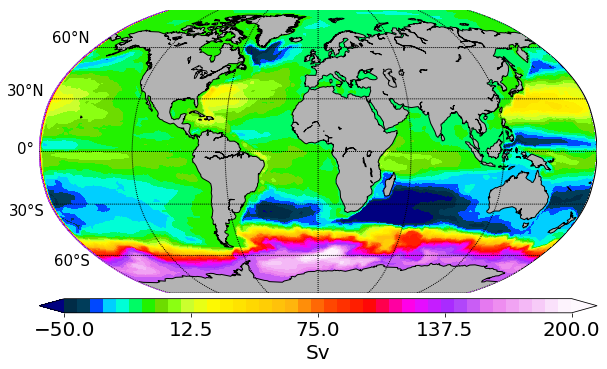

In [41]:
from scipy.interpolate import griddata
from scipy import interpolate
from matplotlib import cm

fig = plt.figure(figsize=(10,6))
cbartext, cont = 'Sv', [-50., 200.]
cmap=cm.gist_ncar
shifted_cmap = shiftedColorMap(cmap, midpoint=0.25, name='shifted')

map = Basemap(projection='robin',lon_0=0)
XG,YG=np.meshgrid(X, Y[1:])
XX, YY = map(XG, YG)
map.drawmapboundary(fill_color='0.9')
map.drawcoastlines()
map.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0], fontsize=15)
map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=[0,0,0,1])
im=plt.contourf(XX, YY, strf.T, levels=np.linspace(cont[0], cont[1], 40), cmap=shifted_cmap, extend='both')
map.fillcontinents(color='.7',lake_color='.7')
cbar=map.colorbar(im,"bottom", size="5%", pad="2%")
cbar.set_ticks([round(i,4) for i in np.linspace(cont[0], cont[1], 5)])
cbar.set_label(cbartext, fontsize=fontsize)
cbar.set_label(cbartext, fontsize=fontsize)